Code to create and run linear models for high winds >40kt

In [297]:
#Import required modules
import pandas as pd, xarray as xr, numpy as np, matplotlib.pyplot as plt, sklearn as sk, scipy

In [298]:
#Load in feature and label data
features = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_feature_data.csv')
labels = pd.read_csv('C:/users/benja/downloads/ORIE4741/all_label_data.csv')
features = features.drop(columns = ['Unnamed: 0'])
labels = labels.drop(columns = ['Unnamed: 0'])

In [299]:
#Remove data points with more than half of features missing
dropidxs = []
for i in range(features.shape[0]):
  if pd.isnull(features).sum(axis = 1)[i] > 0.5*features.shape[1]:
    dropidxs.append(i)
print('Dropping ' + str(len(dropidxs)) + ' data points due to missing data')

features = features.drop(index = dropidxs).reset_index(drop=True)
labels = labels.drop(index = dropidxs).reset_index(drop=True)

Dropping 75 data points due to missing data


In [300]:
#Filter to keep only high winds
features = features[labels['sknt'] > 40]
labels = labels[labels['sknt'] > 40]

In [301]:
features.reset_index(drop=True, inplace=True)

In [302]:
labels.reset_index(drop=True, inplace=True)

Train/Test/Validate Split

In [303]:
from numpy import random
#Set random seed for reproducible results
np.random.seed(1)

In [304]:
#Randomly select indices for training and testing data

other_indices = []
test_indices = []
validate_indices = []
train_indices = []

#Get train indices randomly (60% of dataset)
while len(train_indices) < int(np.round(features.shape[0] * 0.6)):
  i = np.random.randint(0, features.shape[0])
  if i not in train_indices:
    train_indices.append(i)

#Get indices not in train_indices
for i in range(features.shape[0]):
  if i not in train_indices:
    other_indices.append(i)

#Split other_indices into validate indices and test indices evenly
while len(validate_indices) < int(np.round(len(other_indices) * 0.5)):
  i = np.random.randint(0, len(other_indices))
  if other_indices[i] not in validate_indices:
    validate_indices.append(other_indices[i])

for i in range(len(other_indices)):
  if other_indices[i] not in validate_indices:
    test_indices.append(other_indices[i])

#Convert indices to numpy arrays
train_indices = np.array(train_indices)
validate_indices = np.array(validate_indices)
test_indices = np.array(test_indices)

#Make array containing train and validate indices (for use in cross-validation)
train_and_validate_indices = []
train_and_validate_indices.extend(train_indices)
train_and_validate_indices.extend(validate_indices)

Train/Validate/Test Split and Standardize Data

In [305]:
#Split into training, validation, and testing features and labels
training_features_array = features.iloc[train_indices].values
training_labels_array = labels.iloc[train_indices, 1:].values
validate_features_array = features.iloc[validate_indices].values
validate_labels_array = labels.iloc[validate_indices, 1:].values
testing_features_array = features.iloc[test_indices].values
testing_labels_array = labels.iloc[test_indices, 1:].values

#Standardize features
from sklearn.preprocessing import StandardScaler
all_features_array_scaled = StandardScaler().fit(np.array(features)).transform(np.array(features))

#Get standardized training, validation, and testing features
training_features_array_scaled = all_features_array_scaled[train_indices, :]
validate_features_array_scaled = all_features_array_scaled[validate_indices, :]
testing_features_array_scaled = all_features_array_scaled[test_indices, :]

0.5893101507579177
0.5835108392860437


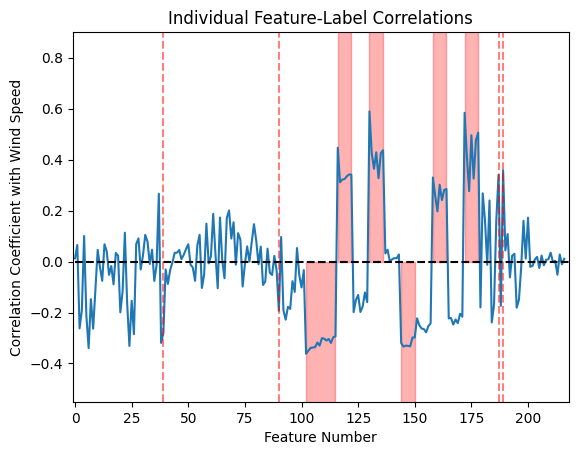

In [306]:
#Reproduce plot from EDA for high wind speed data
all_ccs = []
for i in range(features.shape[1]):
  all_ccs.append(np.corrcoef(features.iloc[:, i], labels['sknt'])[0][1])

#Plot all correlation coefficients between features and wind speed
plt.plot(all_ccs)
print(max(all_ccs))
print(np.corrcoef(features['ws8001'], labels['sknt'])[0][1])
plt.xlabel('Feature Number')
plt.ylabel('Correlation Coefficient with Wind Speed')
plt.title('Individual Feature-Label Correlations')
 
plt.ylim([-0.55, 0.9])
plt.xlim([-1, 218])
plt.plot([0, 218], [0, 0], '--k')

#Highlight individual features / groups of features
plt.plot([39, 39], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5) #t80026
plt.plot([90, 90], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5) #tsfc76
plt.fill_betweenx([-1, 0], 102, 115, color = 'r', alpha = 0.3) #tsfc/tdsfc
plt.fill_betweenx([0, 1], 116, 122, color = 'r', alpha = 0.3) #usfc
plt.fill_betweenx([0, 1], 130, 136, color = 'r', alpha = 0.3) #wssfc
plt.fill_betweenx([-1, 0], 144, 150, color = 'r', alpha = 0.3) #t800
plt.fill_betweenx([0, 1], 158, 164, color = 'r', alpha = 0.3) #u800
plt.fill_betweenx([0, 1], 172, 178, color = 'r', alpha = 0.3) #u800
plt.plot([187, 187], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5)#ws5am
plt.plot([189, 189], [-0.55, 0.9], c = 'r', linestyle = '--', alpha = 0.5)#gust5am


Single Predictor OLS

In [307]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Get cross-validation score from 5-fold CV using train and validate indices together
one_pred_OLS_cv = cross_val_score(LinearRegression(), features.iloc[train_and_validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Train model on training set and record validation set R^2
one_pred_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_validscore = one_pred_OLS_trainonly.score(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print cross-validation and validation-set R^2 values
print(("Cross-validation mean R squared: " + str(one_pred_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(one_pred_OLS_cv.std())))
print(("Validation set R squared is: " + str(one_pred_OLS_validscore)))

Cross-validation mean R squared: 0.358954846474046
Cross-validation stdev R squared: 0.07935742145789429
Validation set R squared is: 0.3883383060310661


Text(0.5, 1.0, 'Single-predictor OLS Predicted vs. Actual Wind Speed')

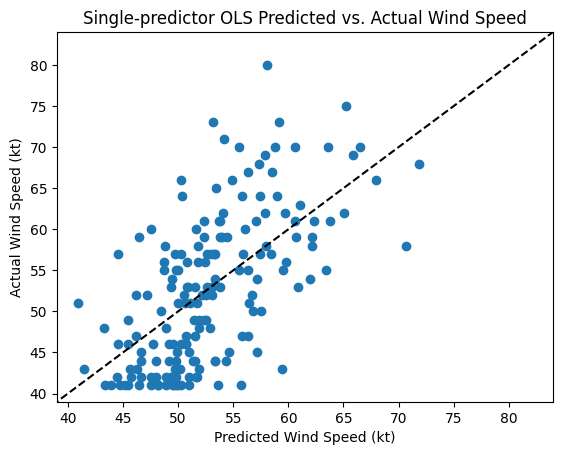

In [308]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Plot model predictions vs actual for validation set
one_pred_OLS = LinearRegression().fit(features.iloc[train_indices]['ws8001'].values.reshape(-1, 1), labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
one_pred_OLS_predictions = one_pred_OLS.predict(features.iloc[validate_indices]['ws8001'].values.reshape(-1, 1))

plt.scatter(one_pred_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])

#label axes
plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('Single-predictor OLS Predicted vs. Actual Wind Speed')

All-Predictors Linear Model for Non-Standardized Data

In [309]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Get 5-fold cross-validation scores for models trained on subset of train and validate features together
multi_pred_unscaled_OLS_cv = cross_val_score(LinearRegression(), features.iloc[train_and_validate_indices].values, labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Train model on training set only and get validation R^2
multi_pred_unscaled_OLS_trainonly = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_validscore = multi_pred_unscaled_OLS_trainonly.score(features.iloc[validate_indices].values, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print CV and validation set scores
print(("Cross-validation mean R squared: " + str(multi_pred_unscaled_OLS_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_unscaled_OLS_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_unscaled_OLS_validscore)))

Cross-validation mean R squared: 0.45827075366575476
Cross-validation stdev R squared: 0.07442209025335808
Validation set R squared is: 0.3866327564598965


Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

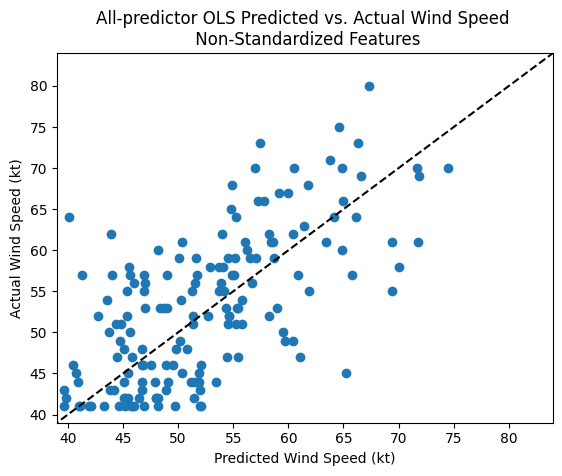

In [310]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Fit linear regression model using training set only, get predictions on validation set
multi_pred_unscaled_OLS = LinearRegression().fit(features.iloc[train_indices].values, labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_unscaled_OLS_predictions = multi_pred_unscaled_OLS.predict(features.iloc[validate_indices].values)

#Make scatterplot of predictions vs. true values
plt.scatter(multi_pred_unscaled_OLS_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])

#Label axes
plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Non-Standardized Features')

All-Predictors Linear Model for Standardized Data

In [311]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Get 5-fold CV scores from model fit to training and validation sets
multi_pred_OLS_standardized_cv = cross_val_score(LinearRegression(), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Fit model using training set only, get R^2 for validation set
multi_pred_OLS_standardized_trainonly = LinearRegression().fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_validscore = multi_pred_OLS_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print R^2 results from CV and validation set
print(("Cross-validation mean R squared: " + str(multi_pred_OLS_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_OLS_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_OLS_standardized_validscore)))

Cross-validation mean R squared: 0.459230147211819
Cross-validation stdev R squared: 0.07394837954465719
Validation set R squared is: 0.3857315974973581


In [312]:
#Make a slight perturbation (called a) to features
a = np.zeros(len(all_features_array_scaled[test_indices, :][0]))
a[5] = 1
a

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [313]:
#Predict wind speed without a perturbation for the first test data point
multi_pred_OLS_standardized.predict(all_features_array_scaled[test_indices[0], :].reshape(1, -1))

array([[45.7911805]])

In [314]:
#Predict wind speed with perturbation to the first test data point [note significant difference]
multi_pred_OLS_standardized.predict((all_features_array_scaled[test_indices[0], :] + a).reshape(1, -1))

array([[-9.72548409e+12]])

Text(0.5, 1.0, 'All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

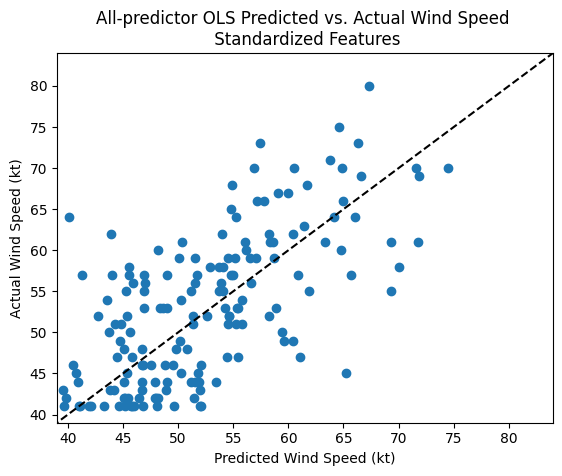

In [315]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#Fit linear regression model to standardized data using only training data points, get model predictions
multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_OLS_standardized_predictions = multi_pred_OLS_standardized.predict(all_features_array_scaled[validate_indices])

#Make scatterplot of predicted vs. actual wind speeds
plt.scatter(multi_pred_OLS_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])

#Label axes
plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor OLS Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature OLS with Standardized Data: \n Feature Coefficients')

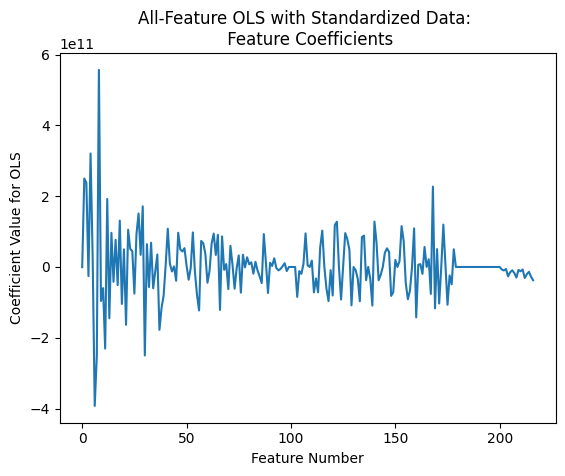

In [316]:
#Plot feature coefficients of model
plt.plot(multi_pred_OLS_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for OLS')
plt.title('All-Feature OLS with Standardized Data: \n Feature Coefficients')

In [317]:
#Perform bootstrapping to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
#Take 50 bootstrap samples
for iter in range(50):
  bootstrap_indices = []
  #In each sample, pick 50 percent of training data points
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  #Fit model to bootstrap sample and get R^2 on validation set
  multi_pred_OLS_standardized = LinearRegression().fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_OLS_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  #Store model coefficients
  w = multi_pred_OLS_standardized.coef_[0]
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(w)
  
#Print mean and stdev of bootstrap R^2 results
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: -9.965073170779639e+22
StDev of bootstrapped R squared is: 5.042998189789962e+23


In [318]:
#Print standard deviation of bootstrap feature coefficients
np.array(bootstrap_w).std(axis = 0)

array([6.45863450e+13, 5.44776937e+13, 5.73109997e+13, 6.50548072e+13,
       1.71170993e+13, 3.51960770e+13, 2.52557347e+13, 1.07193921e+13,
       1.70791365e+13, 6.40333063e+12, 1.22438809e+13, 1.26764957e+13,
       1.16639777e+13, 1.35496474e+13, 1.15390284e+13, 1.47008114e+13,
       8.62456562e+12, 1.22127159e+13, 1.12515975e+13, 1.21685555e+13,
       1.21192231e+13, 1.32624291e+13, 1.38337849e+13, 1.18739401e+13,
       1.35460259e+13, 1.01369224e+13, 1.32695664e+13, 7.64178335e+12,
       9.86623753e+12, 9.66145003e+12, 1.11847991e+13, 9.37476998e+12,
       7.27752831e+12, 7.23004177e+12, 6.64875758e+12, 5.79371531e+12,
       2.54013454e+12, 3.95750429e+12, 5.18484608e+12, 5.10462409e+12,
       4.86397384e+12, 4.20101972e+12, 4.93518483e+12, 3.81951945e+12,
       5.25389093e+12, 3.70503844e+12, 5.71548797e+12, 5.77674797e+12,
       8.40154648e+12, 4.94850574e+12, 4.79827344e+12, 3.87601500e+12,
       4.20287099e+12, 3.43877807e+12, 3.85271091e+12, 4.52259446e+12,
      

All-Predictors Ridge Regression Linear Model for Standardized Data, L2 Regularization

Cross-validation mean R squared: 0.5548762313775777
Cross-validation stdev R squared: 0.04805717014879324
Validation set R squared is: 0.5183814602792496


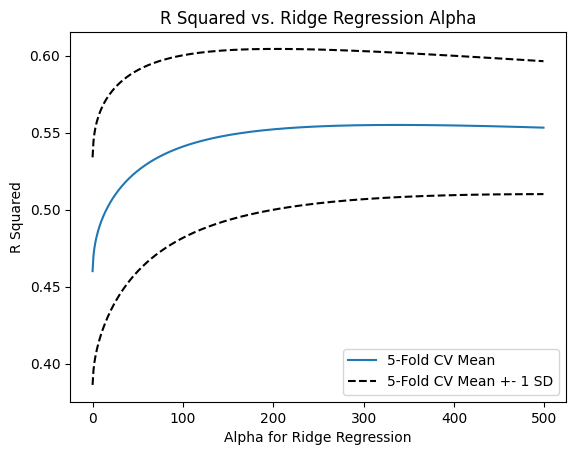

In [319]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#Store means and stds for cross-validation
cv_means = []
cv_stds = []

#Iterate through values of alpha (ridge_coeff)
for ridge_coeff in np.arange(0.05, 500, 1):
  #Get cross-validation scores from 5-fold cross validation
  multi_pred_ridge_standardized_cv = cross_val_score(Ridge(ridge_coeff), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_ridge_standardized_cv.mean())
  cv_stds.append(multi_pred_ridge_standardized_cv.std())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

#Plot cross-validation scores and standard deviation
plt.plot(np.arange(0.05, 500, 1), cv_means, label = '5-Fold CV Mean')
plt.plot(np.arange(0.05, 500, 1), cv_means + cv_stds, '--k', label = "5-Fold CV Mean +- 1 SD")
plt.plot(np.arange(0.05, 500, 1), cv_means - cv_stds, '--k')
plt.xlabel('Alpha for Ridge Regression')
plt.ylabel('R Squared')
plt.title('R Squared vs. Ridge Regression Alpha')
plt.legend()

#Get R^2 mean and stdev from 5-fold CV with alpha = 5
multi_pred_ridge_standardized_cv = cross_val_score(Ridge(300), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))

#Fit ridge regression to training dataset only and get R^2 for validation set
multi_pred_ridge_standardized_trainonly = Ridge(300).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_validscore = multi_pred_ridge_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))

#Print R^2 results
print(("Cross-validation mean R squared: " + str(multi_pred_ridge_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_ridge_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_ridge_standardized_validscore)))

In [320]:
#Perform bootstrapping to estimate prediction variance
bootstrap_pred_scores = []
bootstrap_w = []
#Take 50 bootstrap samples
for iter in range(50):
  bootstrap_indices = []
  #Each sample has half the number of data points as training set
  for i in range(int(round(len(train_indices) / 2))):
    bootstrap_indices.append(train_indices[np.random.randint(0, len(train_indices))])
  bootstrap_indices = np.array(bootstrap_indices)
  #Fit ridge regression with alpha = 300, keep track of R^2 and feature coefficients (entries of w)
  multi_pred_ridge_standardized = Ridge(300).fit(all_features_array_scaled[bootstrap_indices, :], labels.iloc[bootstrap_indices]['sknt'].values.reshape(-1, 1))
  score = multi_pred_ridge_standardized.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
  bootstrap_pred_scores.append(score)
  bootstrap_w.append(multi_pred_ridge_standardized.coef_[0])
  
#Print bootstrap mean R^2 and stdev R^2
print('Mean of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).mean()))
print('StDev of bootstrapped R squared is: ' + str(np.array(bootstrap_pred_scores).std()))

Mean of bootstrapped R squared is: 0.4880067897657925
StDev of bootstrapped R squared is: 0.023685032739529797


In [321]:
#Print stdev. of feature coefficients (entries of w) across the 50 bootstrap models
np.array(bootstrap_w).std(axis = 0)

array([0.10004067, 0.09175472, 0.08911047, 0.08819045, 0.0867254 ,
       0.0864144 , 0.07395762, 0.10368999, 0.09186281, 0.13838006,
       0.11152548, 0.11527998, 0.1046536 , 0.09001508, 0.1083108 ,
       0.09307767, 0.10099363, 0.08878097, 0.09163504, 0.10425168,
       0.12242099, 0.10754124, 0.06811186, 0.0940111 , 0.08624729,
       0.10194216, 0.09635034, 0.12545267, 0.10780866, 0.11264094,
       0.08578581, 0.12057166, 0.07809234, 0.11219421, 0.10281641,
       0.14164897, 0.12852838, 0.09333854, 0.09967405, 0.10401571,
       0.11064864, 0.09212195, 0.07427018, 0.08837456, 0.09378566,
       0.11319591, 0.09153427, 0.08375796, 0.07930136, 0.10083691,
       0.09216419, 0.09776026, 0.11284321, 0.10644526, 0.10915429,
       0.07916284, 0.08630013, 0.08804529, 0.09258728, 0.1172456 ,
       0.08461719, 0.10239715, 0.07822822, 0.1116088 , 0.09936729,
       0.10794303, 0.08178555, 0.08747808, 0.08884478, 0.06993057,
       0.09328316, 0.08355801, 0.10041152, 0.06691116, 0.08400

Text(0.5, 1.0, 'All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

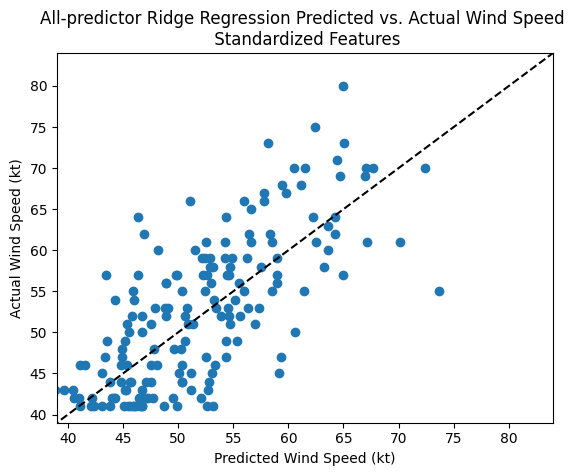

In [322]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

#Fit ridge regression with alpha = 300 to training data and make predictions on validation set
multi_pred_ridge_standardized = Ridge(300).fit(all_features_array_scaled[train_indices], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_ridge_standardized_predictions = multi_pred_ridge_standardized.predict(all_features_array_scaled[validate_indices])

#Plot predictions vs. actual wind speed
plt.scatter(multi_pred_ridge_standardized_predictions, labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
plt.plot([0, 85], [0, 85], '--k')
plt.ylim([39, 84])
plt.xlim([39, 84])


plt.xlabel('Predicted Wind Speed (kt)')
plt.ylabel('Actual Wind Speed (kt)')
plt.title('All-predictor Ridge Regression Predicted vs. Actual Wind Speed \n Standardized Features')

Text(0.5, 1.0, 'All-Feature Ridge Regression (alpha = 300) with Standardized Data: \n Feature Coefficients')

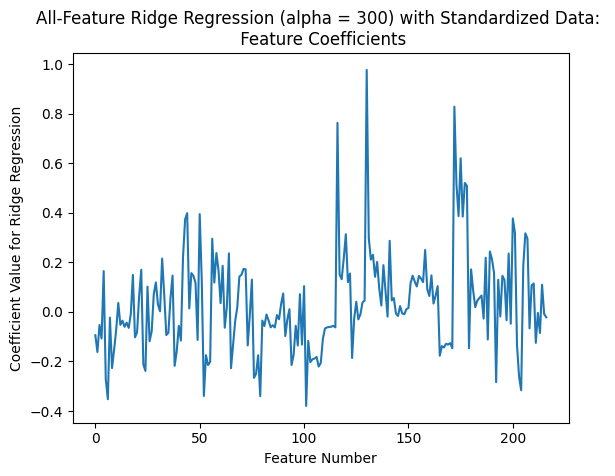

In [323]:
#Plot feature coefficients
plt.plot(multi_pred_ridge_standardized.coef_[0])
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Ridge Regression')
plt.title('All-Feature Ridge Regression (alpha = 300) with Standardized Data: \n Feature Coefficients')

All-Predictors Lasso Regression Linear Model for Standardized Data, L1 Regularization

Cross-validation mean R squared: 0.5555368160920446
Cross-validation stdev R squared: 0.029038001552192928
Validation set R squared is: 0.5593214998179672
Test set R squared is: 0.5159440860597689


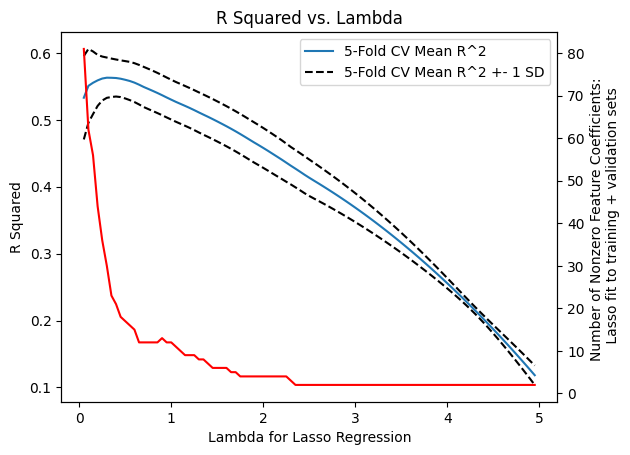

In [324]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

#Store CV means, stdevs, and number of nonzero feature coefficients
cv_means = []
cv_stds = []
nonzeros = []
#Iterate through lasso coefficients (lambda)
for lasso_coeff in np.arange(0.05, 5, 0.05):
  #Get cross-validation scores using training and validation sets, track number of nonzero feature coefficients
  multi_pred_lasso_standardized_cv = cross_val_score(Lasso(lasso_coeff), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  #Fit lasso to training and validation sets
  multi_pred_lasso_standardized = Lasso(lasso_coeff).fit(all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
  cv_means.append(multi_pred_lasso_standardized_cv.mean())
  cv_stds.append(multi_pred_lasso_standardized_cv.std())
  nonzeros.append((abs(multi_pred_lasso_standardized.coef_) > 0).sum())

cv_means = np.array(cv_means)
cv_stds = np.array(cv_stds)

#Plot cross-validation R^2 mean and standard deviation and number of nonzero feature coefficients
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0.05, 5, 0.05), cv_means, label = '5-Fold CV Mean R^2')
ax.plot(np.arange(0.05, 5, 0.05), cv_means + cv_stds, '--k', label = "5-Fold CV Mean R^2 +- 1 SD")
ax.plot(np.arange(0.05, 5, 0.05), cv_means - cv_stds, '--k')
ax2 = ax.twinx()
ax2.plot(np.arange(0.05, 5, 0.05), nonzeros, 'r', label = 'Nonzero Features')
ax2.set_ylabel("Number of Nonzero Feature Coefficients: \n Lasso fit to training + validation sets")

ax.set_xlabel('Lambda for Lasso Regression')
ax.set_ylabel('R Squared')
plt.title('R Squared vs. Lambda')
#plt.legend(loc = 'center right')
ax.legend()

#Get cross-validation score on train and validation sets from 5-fold CV
multi_pred_lasso_standardized_cv = cross_val_score(Lasso(0.6), all_features_array_scaled[train_and_validate_indices, :], labels.iloc[train_and_validate_indices]['sknt'].values.reshape(-1, 1))
#Fit model to training set only, get R^2 score for validation set and test set
multi_pred_lasso_standardized_trainonly = Lasso(0.6).fit(all_features_array_scaled[train_indices, :], labels.iloc[train_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_validscore = multi_pred_lasso_standardized_trainonly.score(all_features_array_scaled[validate_indices, :], labels.iloc[validate_indices]['sknt'].values.reshape(-1, 1))
multi_pred_lasso_standardized_testscore = multi_pred_lasso_standardized_trainonly.score(all_features_array_scaled[test_indices, :], labels.iloc[test_indices]['sknt'].values.reshape(-1, 1))

#Print R^2 values
print(("Cross-validation mean R squared: " + str(multi_pred_lasso_standardized_cv.mean())))
print(("Cross-validation stdev R squared: " + str(multi_pred_lasso_standardized_cv.std())))
print(("Validation set R squared is: " + str(multi_pred_lasso_standardized_validscore)))
print(("Test set R squared is: " + str(multi_pred_lasso_standardized_testscore)))

Text(0.5, 1.0, 'All-Feature Lasso Regression (lambda = 0.6) with Standardized Data: \n Feature Coefficients')

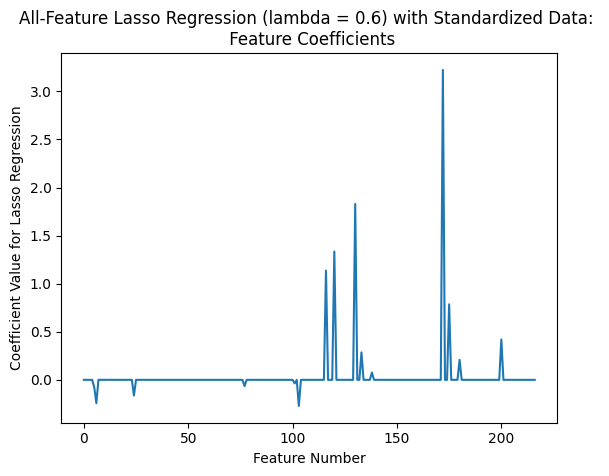

In [325]:
#Plot feature coefficients for lasso regression with lambda = 1
plt.plot(multi_pred_lasso_standardized_trainonly.coef_)
plt.xlabel('Feature Number')
plt.ylabel('Coefficient Value for Lasso Regression')
plt.title('All-Feature Lasso Regression (lambda = 0.6) with Standardized Data: \n Feature Coefficients')

In [357]:
multi_pred_lasso_standardized_trainonly.coef_[172]

3.223382397197657

In [356]:
features.columns.values[130]

'wssfc1'